In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
import seaborn as sns; sns.set(color_codes=True)
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
# from scipy.cluster.hierarchy import dendrogram, linkage
from collections import namedtuple
from numpy import nan

from scipy.spatial.distance import pdist, squareform
# import plotly.graph_objects as go
# import plotly.figure_factory as ff
from geopy.geocoders import Nominatim
from sklearn.metrics import silhouette_score
from ete3 import Tree, faces, AttrFace, TreeStyle, NodeStyle, TextFace, CircleFace

from utils import (
    clean_data, 
    create_pivot, 
    add_metadata_to_pivot,
    get_linkage,
    get_cluster_map,
    correlation_matrix,
    join_on_ska_labels,
    wrap_clustermap_and_mismatches,
    hierarchical_clustering,
    get_silhouette_score,
)

### Script Structure:

* read in metadata file (sample_genus_and_species.csv)
* read in ska distances.distances.tsv
* data clean: 
    * make join key indeces consistent
    * assert no missing data
    * remove waters
    * data reorganization:
        * create pivot table (with SNP_distance values) with multi-index including:
            * genus
            * species
            * corrected_species
            * sample_prefix
* OA:
    * heatmap with maca data (shows snp distance of zero)
    * clustermap with non truncated sketches and some reference genomes
    * silhouette scores for ska (need sourmash raw data)
    
* visualizations/ exploration
    * clustermap with non-truncated sketches (for different k sizes [3, 9, 12, 15, 24])
    * hierarchical clustering
    * do comparison graph to overlay most similar species for each comparison
        * organize color palette for similar species to show up in the same familiy of colors

* Data Output:
    * output entries that were potentially mislabeled
        * show clusters that are heterogeneous and output samples that were in the minority 
    
    
    
* create database, or grab other reference genomes for comparisons
        
        
        
* show pileups of different genes to show missing overlaps between different species
* how does this change with differences between the genomes (introducing snps)
     * show how sourmash discards huge regions based on snp difference 
     * do line up with sourmash vs. snps
     * resolution lost with dendogram for sourmash (problems with the big differences early on making hte dnedogram come together later)
     * plots for original, annd dendrogram
     * show plot with reference and expect people talk about diffs between fastq fasta. 
     * why we chose to look at ska
     * method ska
     * plots ska with dendogram
     * sourmash hashing (random sampling)
     * list the name 

<hr>

## Data Retrieval/Cleaning/Formatting

In [4]:
# with location metadata:

new_metadata = pd.read_csv(
    "/Users/phoenix.logan/code/skeeters/data/metadata/CMS001_CMS002_MergedAnnotations.csv", 
    header = 0, 
#     index_col = "czbiohub-mosquito_sequences_id",
)

species_id = new_metadata[[
    "czbiohub-mosquito_sequences_id",
    "visual_genus", 
    "visual_species", 
    "sourmash_species", 
    "sourmash_genus"
]]

species_id.rename(
    columns = {
#         'visual_genus': 'genus',
#         'visual_species': 'species',
        'compute_species': 'sourmash_species',
        'compute_genus': 'sourmash_genus',
        'czbiohub-mosquito_sequences_id': ''
    }, 
    inplace = True
)
species_id.set_index("", inplace=True)

len(species_id) # 161
species_id.head()

/Users/phoenix.logan/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,visual_genus,visual_species,sourmash_species,sourmash_genus
,,,,
CMS_001_RNA_A_S1,Culex,erythrothorax,erythrothorax,Culex
CMS_002_RNA_A_S1,Culex,tarsalis,tarsalis,Culex
CMS_003_RNA_A_S2,Culiseta,particeps,particeps,Culiseta
CMS_004_RNA_A_S2,Culex,pipiens,pipiens,Culex
CMS_005_RNA_A_S3,Culiseta,incidens,incidens,Culiseta


In [31]:
nm = pd.read_csv("metadata_11_18_local.csv")

waters = [
        "CMS_water1_S11",
        "CMS_water2_S24",
        "CMS_water3_Qiagen_S26",
        "CMS_water4_Zymo_S27",
        "CMS_water5_RNA_A_S12",
        "CMS_002_Water1_Rb_S127_L004",
        "CMS_002_Water2_Rb_S139_L004",
        "CMS_002_Water3_Rb_S151_L004",
        "CMS_002_Water4_Rb_S163_L004",
        "CMS_002_Water5_Rb_S175_L004",
        "CMS_002_Water6_Rb_S187_L004",
        "CMS_002_Water7_Rb_S199_L004",
        "CMS_002_Water8_Rb_S11_L004",   
    ]

new_data = {
    "id": waters,
    "read1": ["/mnt/data_lg/phoenix/data/raw_fastqs/{w}_R1_001.fastq.gz".format(w=w) for w in waters],
    "read2": ["/mnt/data_lg/phoenix/data/raw_fastqs/{w}_R2_001.fastq.gz".format(w=w) for w in waters]
    
}

nd = pd.DataFrame.from_dict(new_data)

all_meta = pd.concat([nm, nd], axis=0)
all_meta.to_csv("all_meta_11_21.csv", index=False)

In [5]:
import pandas as pd
import seaborn as sns; sns.set(color_codes=True)
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster
import scipy.cluster.hierarchy as shc
# from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.metrics import silhouette_score


def clean_data(dd_tsv, tailing, metadata):
    '''
    clean data and remove water samples
    '''
    
    # read in data tables with sample distances computed with ska (split kmer analysis)
    dd_tsv.columns = dd_tsv.columns.str.replace(" ", "_")
    
    # Add prefix columns and size
    dd_tsv["Sample_1"] = dd_tsv.apply(lambda row: row["Sample_1"].split(tailing)[0], axis=1)
    dd_tsv["Sample_2"] = dd_tsv.apply(lambda row: row["Sample_2"].split(tailing)[0], axis=1)

    # re-organize columns
    dd_tsv = dd_tsv[["Sample_1", 
                     "Sample_2", 
                     "Matches", 
                     "Mismatches", 
                     "Jaccard_Index",
                     "Mash-like_distance",
                     "SNPs",
                     "SNP_distance",
                    ]]
    
    # fix samples that need their file names changed
    # replace row values
    dd_tsv.replace({
        'CMS_0015_RNA_A_S13': 'CMS_015_RNA_A_S13',
        'CMS_001_16_S5_L001': 'CMS_006_RNA_A_S5',  # wierd case
        'CMS_001_17_S6_L001': 'CMS_017_RNA_A_S6',
        'CMS_001_32_S7_L001': 'CMS_032_RNA_A_S7',
        'CMS_037_RNA_A_S21': 'CMS_037_RNA_A_S21',
        'CMS_058_RNA_A_S9':  'CMS_058_RNA_A_S9'
    }, inplace=True)

    # water_samples = metadata[
    #     (metadata.visual_species.isnull()) 
    #     & 
    #     (metadata.sourmash_species.isnull())
    # ].index
    
    # # remove data with no species label (water samples)
    # filtered_out_water = dd_tsv[~(
    #     (dd_tsv.Sample_1.isin(water_samples)) 
    #     | 
    #     (dd_tsv.Sample_2.isin(water_samples))
    # )]

    #return filtered_out_water
    return dd_tsv


def create_pivot(df, values="SNP_distance", diagonal=0):    
    ''' create pivot tables with sample 1 and sample 2 correlations'''
    
    dd_tsv_pivot = df.pivot(
        columns="Sample_1", 
        index="Sample_2", 
        values=values
    )
    dd_tsv_pivot = dd_tsv_pivot.loc[dd_tsv_pivot.columns, :]
    np.fill_diagonal(dd_tsv_pivot.values, diagonal)
    dd_tsv_pivot = dd_tsv_pivot.fillna(0) + dd_tsv_pivot.T.fillna(0) - np.diag(dd_tsv_pivot.values.diagonal())
    return dd_tsv_pivot


def add_metadata_to_pivot(df, metadata_fields, metadata):
    """join metadata onto pivot table for axis labeling"""
    
    dd_tsv_pivot_w_labels = pd.merge(
        df.reset_index(), 
        metadata[metadata_fields], 
        how='left',
        left_on="Sample_1", 
        right_index=True, 
    ).reset_index().set_index(
        ["Sample_1"] + metadata_fields
    ).drop(["index"], axis=1)
    
    return dd_tsv_pivot_w_labels


def get_linkage(pivot_df):
    '''clustering linkage'''
    
    cdist = scipy.spatial.distance.squareform(pivot_df)
    return scipy.cluster.hierarchy.linkage(cdist, method="ward")


def get_cluster_map(pivot_df, linkage, num_clusters, extra=True):
    """cluster distance matrix and re-assign species as cluster species mode"""
    
    clusters = fcluster(linkage, num_clusters, criterion='maxclust')
    
    cluster_map = pd.DataFrame()
    
    if extra:
        cluster_map['visual_genus'] = pivot_df.index.get_level_values(1)
        cluster_map['visual_species'] = pivot_df.index.get_level_values(2)
        cluster_map['sourmash_genus'] = pivot_df.index.get_level_values(3)
        cluster_map['sourmash_species'] = pivot_df.index.get_level_values(4)
        
    cluster_map["Sample_1"] = pivot_df.columns
    cluster_map['cluster'] = clusters
    cluster_map.set_index("Sample_1", inplace=True)

    cluster_chunks = []
    for clust in cluster_map.cluster.unique():
        subset = cluster_map[cluster_map.cluster == clust]
        species_mode = subset.visual_species.mode()[0]
        genus_mode = subset[subset["visual_species"] == species_mode].visual_genus.values[0]
        subset["ska_species"] = species_mode
        subset["ska_genus"] = genus_mode
        cluster_chunks.append(subset)

    cluster_map_w_ska = pd.concat(cluster_chunks)
#     cluster_map_w_ska = cluster_map_w_ska[[
#         "genus", 
#         "species", 
#         "sourmash_genus",
#         "sourmash_species", 
#         "ska_genus",
#         "ska_species"
#     ]]
    return cluster_map_w_ska

    
# def correlation_matrix(pivot_w_labels, linkage, cluster_map, figsize=(60,60)):
#     '''correlatian matrix comparing visual, sourmash, and ska species assignment'''
    
#     original_species_coloring = dict(
#         zip(
#             pivot_w_labels.index.get_level_values(2).unique(), 
#             sns.color_palette("bright", 12)
#         )
#     )
    
#     sourmash_species_coloring = dict(
#         zip(
#             pivot_w_labels.index.get_level_values(4).unique(), 
#             sns.color_palette("deep", 12)
#         )
#     )
    
#     ska_species_coloring = dict(
#         zip(
#             pivot_w_labels.index.get_level_values(6).unique(), 
#             sns.color_palette("dark", 13)
#         )
#     )   
    
#     pivot_index = pivot_w_labels.index
    
#     key_colors_original = pivot_index.get_level_values(2).map(original_species_coloring)
#     key_colors_sourmash = pivot_index.get_level_values(4).map(sourmash_species_coloring)
#     key_colors_ska = pivot_index.get_level_values(6).map(ska_species_coloring)
    
#     key_colors_labels = [
#         key_colors_original, 
#         key_colors_sourmash, 
#         key_colors_ska
#     ]

#     return sns.clustermap(
#             pivot_w_labels.reset_index().drop([
#                 "visual_genus", 
#                 "visual_species", 
#                 "sourmash_genus",
#                 "sourmash_species",
#                 "ska_genus",
#                 "ska_species"
#             ], axis=1).set_index("Sample_1"),
#             metric="correlation", 
#             row_colors=key_colors_labels, 
#             col_colors=key_colors_labels,
#             figsize=figsize,
#             col_linkage=linkage,
#             row_linkage=linkage,
#             cbar_kws={'label': 'distance'},
#             xticklabels=pivot_w_labels.index.get_level_values(4),
#             yticklabels=pivot_w_labels.index.get_level_values(6)
#     )


def join_on_ska_labels(fp, metadata, tailing, k, values="SNP_distance"):
    '''read in fp and create pivot distance matrix with old and new species labels'''
    
    df_cleaned = clean_data(
        fp, 
        metadata=metadata,
        tailing=tailing
    )

    dd_pivot = create_pivot(
        df_cleaned, 
        values=values, 
        diagonal=0
    )

    metadata_fields = [
        "visual_genus", 
        "visual_species", 
        "sourmash_genus",
        "sourmash_species"
    ]

    dd_pivot_w_labels = add_metadata_to_pivot(
        dd_pivot, 
        metadata_fields, 
        metadata=metadata
    )

    linkage = get_linkage(dd_pivot)

    cluster_map = get_cluster_map(
        dd_pivot_w_labels, 
        linkage, 
        k, 
        extra=True
    )

    ska_metadata_fields = metadata_fields + ["ska_genus", "ska_species"]

    final_pivot_w_labels = add_metadata_to_pivot(
        dd_pivot, 
        ska_metadata_fields, 
        metadata=cluster_map
    )
    
    return final_pivot_w_labels, cluster_map, linkage


def wrap_clustermap_and_mismatches(fp, metadata, tailing, k=10, figsize=(60,60), values="SNP_distance", diagonal=0):
    '''create clustermap with new and old species assigned labels'''
    
    dd_pivot_w_ska_labels, cluster_map, linkage = join_on_ska_labels(
        fp, 
        metadata, 
        tailing,
        k,
        values=values
    )
    
    c = correlation_matrix(
        dd_pivot_w_ska_labels, 
        linkage, 
        cluster_map, 
        figsize=(60,60)
    )
    
    #return dd_pivot_w_ska_labels
    return dd_pivot_w_ska_labels.query(
        'visual_species != sourmash_species | ' + 
        'visual_species != ska_species | ' + 
        'sourmash_species != ska_species'
    )


def hierarchical_clustering(fp, metadata, tailing, k, values="SNP_distance"):
    
    
    dd_pivot_w_ska_labels, *_ = join_on_ska_labels(
        fp, 
        metadata, 
        tailing, 
        k,
        values=values
    )
    
    cdist = scipy.spatial.distance.squareform(dd_pivot_w_ska_labels)
    Z = shc.linkage(cdist, method="ward")
    fig = plt.figure(figsize=(25, 10))

#     ax = plt.gca()
#     xlbls = ax.get_ymajorticklabels()

#     for lbl in xlbls:
#         lbl.set_color(ska_species_coloring[lbl])
    
    dn = shc.dendrogram(
        Z, 
        leaf_font_size=8, 
        labels=dd_pivot_w_ska_labels.index.get_level_values(6), 
        color_threshold=0.008
    )
    
    return dn


def get_silhouette_score(fp, metadata, tailing, values="SNP_distance", correlation=False):
    '''use silhouette metric to see how compact and distinct clusters are '''
    
    clean_df = clean_data(
        fp, 
        metadata=metadata,
        tailing=tailing
    )

    pivot_df = create_pivot(
        clean_df, 
        values=values, 
        diagonal=0
    )
    
    cdist = scipy.spatial.distance.squareform(pivot_df)  
    linkage = scipy.cluster.hierarchy.linkage(cdist, method="ward")
    clusters = fcluster(linkage, 10, criterion='maxclust')
    
    cluster_map = pd.DataFrame()
    
    cluster_map["Sample_1"] = pivot_df.columns
    cluster_map['cluster'] = clusters
    cluster_map.set_index("Sample_1", inplace=True)
    
    return silhouette_score(pivot_df, metric="precomputed", labels=cluster_map["cluster"])


def correlation_matrix(pivot_w_labels, linkage, cluster_map, figsize=(60,60)):
    '''correlatian matrix comparing visual, sourmash, and ska species assignment'''
    
    original_species_coloring = dict(
        zip(
            pivot_w_labels.index.get_level_values(2).unique(), 
            sns.color_palette("bright", 12)
        )
    )
    
    sourmash_species_coloring = dict(
        zip(
            pivot_w_labels.index.get_level_values(4).unique(), 
            sns.color_palette("deep", 12)
        )
    )
    
    ska_species_coloring = dict(
        zip(
            pivot_w_labels.index.get_level_values(6).unique(), 
            sns.color_palette("dark", 13)
        )
    )   
    
    pivot_index = pivot_w_labels.reset_index()

    key_colors_original = pivot_index["visual_species"].map(original_species_coloring)
    key_colors_sourmash = pivot_index["sourmash_species"].map(sourmash_species_coloring)
    key_colors_ska = pivot_index["ska_species"].map(ska_species_coloring)

    key_colors_labels = [
        key_colors_original, 
        key_colors_sourmash, 
        key_colors_ska
    ]

    return sns.clustermap(
            pivot_w_labels.reset_index().drop([
                "visual_genus", 
                "visual_species", 
                "sourmash_genus",
                "sourmash_species",
                "ska_genus",
                "ska_species"
            ], axis=1).set_index("Sample_1"),
            metric="correlation", 
            row_colors=key_colors_labels, 
            col_colors=key_colors_labels,
            figsize=figsize,
            col_linkage=linkage,
            row_linkage=linkage,
            cbar_kws={'label': 'distance'},
            xticklabels=pivot_w_labels.index.get_level_values(2),
            yticklabels=pivot_w_labels.index.get_level_values(6)
    )


In [23]:
#read in row distance matrices and cluster
t_raw = pd.read_csv("ksize_15_new.distances.tsv", sep="\t")
t_nf = pd.read_csv("ksize_15.distances.tsv", sep="\t")

print(len(t_raw["Sample 1"].unique()))
print(len(t_nf["Sample 1"].unique()))

in_raw_not_nf = [x for x in t_raw["Sample 1"].unique() if x not in t_nf["Sample 1"].unique()]
print("in raw and not in nf", set(in_raw_not_nf))

in_nf_not_raw = [x for x in t_nf["Sample 1"].unique() if x not in t_raw["Sample 1"].unique()]
print("in nf not in raw", set(in_nf_not_raw))

total_samples = pd.concat(
    [
        t_raw,
        t_nf
    ],
    axis=0
).drop_duplicates()

dd_pivot_w_ska_labels, cluster_map, linkage = join_on_ska_labels(
    total_samples,
    species_id,
    "_ksize_15",
    k=10,
    values="SNP_distance", 
)

#check for that all samples made it into final distance matrix
assert len(dd_pivot_w_ska_labels.index.get_level_values(0)) == 148
# assert all samples are accounted for based on metadata sheet
assert [x for x in species_id.index if x not in dd_pivot_w_ska_labels.index.get_level_values(0)] == []


147
147
in raw and not in nf {'CMS_002_20b_Rb_S132_L004_ksize_15'}
in nf not in raw {'CMS_060_RNA_A_S12_ksize_15'}


/Users/phoenix.logan/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/phoenix.logan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/phoenix.logan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [8]:
dd_pivot_w_ska_labels.index.get_level_values(2).unique()

Index([         'pipiens',    'erythrothorax', 'quinquefasciatus',
                'aegypti',        'particeps',       'albopictus',
               'tarsalis',         'incidens',         'dorsalis',
               'inornata',                nan],
      dtype='object', name='visual_species')

/Users/phoenix.logan/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/phoenix.logan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/phoenix.logan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

,,,,,,,CMS002_053a_Rb_S7_L004,CMS_001_RNA_A_S1,CMS_002_10a_Rb_S119_L004,CMS_002_13a_Rb_S120_L004,CMS_002_16a_Rb_S121_L004,CMS_002_17a_Rb_S122_L004,CMS_002_17b_Rb_S123_L004,CMS_002_17c_Rb_S124_L004,CMS_002_17d_Rb_S125_L004,CMS_002_17e_Rb_S126_L004,...,CMS_051_RNA_A_S8,CMS_052_RNA_A_S7,CMS_053_RNA_A_S8,CMS_054_RNA_A_S11,CMS_055_RNA_A_S9,CMS_056_RNA_A_S10,CMS_057_RNA_A_S11,CMS_058_RNA_A_S9,CMS_059_RNA_A_S10,CMS_060_RNA_A_S12
Sample_1,visual_genus,visual_species,sourmash_genus,sourmash_species,ska_genus,ska_species,,,,,,,,,,,,,,,,,,,,,
CMS002_053a_Rb_S7_L004,Culex,pipiens,Culex,pipiens,Culex,erythrothorax,0.000000,0.000196,0.003406,0.003312,0.013605,0.013986,0.014314,0.014091,0.007164,0.013989,...,0.005177,0.000000,0.000241,0.002081,0.000000,0.000000,0.000118,0.000000,0.004143,0.013287
CMS_002_27b_Rb_S153_L004,Culex,quinquefasciatus,Culex,quinquefasciatus,Culex,pipiens,0.004186,0.003095,0.000204,0.000407,0.006417,0.012862,0.006743,0.006680,0.012264,0.006680,...,0.004888,0.001779,0.003784,0.000281,0.001894,0.001622,0.003295,0.004974,0.000912,0.012054
CMS_002_7a_Rb_S118_L004,Culex,quinquefasciatus,Culex,quinquefasciatus,Culiseta,incidens,0.014795,0.007382,0.006635,0.007339,0.006987,0.015494,0.007251,0.007909,0.014703,0.006858,...,0.014615,0.006660,0.012536,0.006553,0.007454,0.006927,0.006645,0.008153,0.006965,0.001193
CMS_016_RNA_A_S6,Culiseta,inornata,Culiseta,inornata,Culiseta,incidens,0.014257,0.006947,0.005870,0.006357,0.006413,0.012691,0.006447,0.007001,0.013759,0.006827,...,0.013674,0.006643,0.012462,0.006427,0.006718,0.006626,0.006478,0.007310,0.006812,0.000332
CMS_025_RNA_A_S7,Culex,tarsalis,Culiseta,particeps,Culiseta,particeps,0.012912,0.006506,0.006668,0.006927,0.007124,0.013142,0.006676,0.007206,0.012787,0.006822,...,0.013041,0.007105,0.012410,0.006219,0.007060,0.006616,0.006643,0.014682,0.012587,0.001839
CMS_026_RNA_A_S18,Culex,tarsalis,Culiseta,incidens,Culiseta,incidens,0.006088,0.007179,0.005842,0.006129,0.006725,0.006912,0.006747,0.007181,0.007133,0.007186,...,0.012670,0.012385,0.012261,0.011665,0.012661,0.012566,0.012960,0.014146,0.013298,0.002455
CMS_040_RNA_A_S21,Culex,tarsalis,Culex,tarsalis,Culex,quinquefasciatus,0.003570,0.001924,0.001294,0.001276,0.006369,0.012626,0.006213,0.006607,0.012809,0.006600,...,0.004623,0.001993,0.003559,0.001099,0.001800,0.001638,0.001809,0.003463,0.002486,0.010576
CMS_045_RNA_A_S2,Culex,tarsalis,Culex,erythrothorax,Culex,erythrothorax,0.000222,0.000399,0.002248,0.002321,0.007331,0.007578,0.007287,0.007158,0.014699,0.008949,...,0.005739,0.000737,0.000000,0.002240,0.000252,0.000250,0.000353,0.001735,0.004728,0.013507
CMS_058_RNA_A_S9,NaN,NaN,Culex,erythrothorax,Culex,erythrothorax,0.000000,0.000528,0.001679,0.002025,0.006877,0.014364,0.007557,0.007459,0.015198,0.006926,...,0.002230,0.000229,0.000000,0.004081,0.000476,0.000000,0.000687,0.000000,0.002843,0.007224


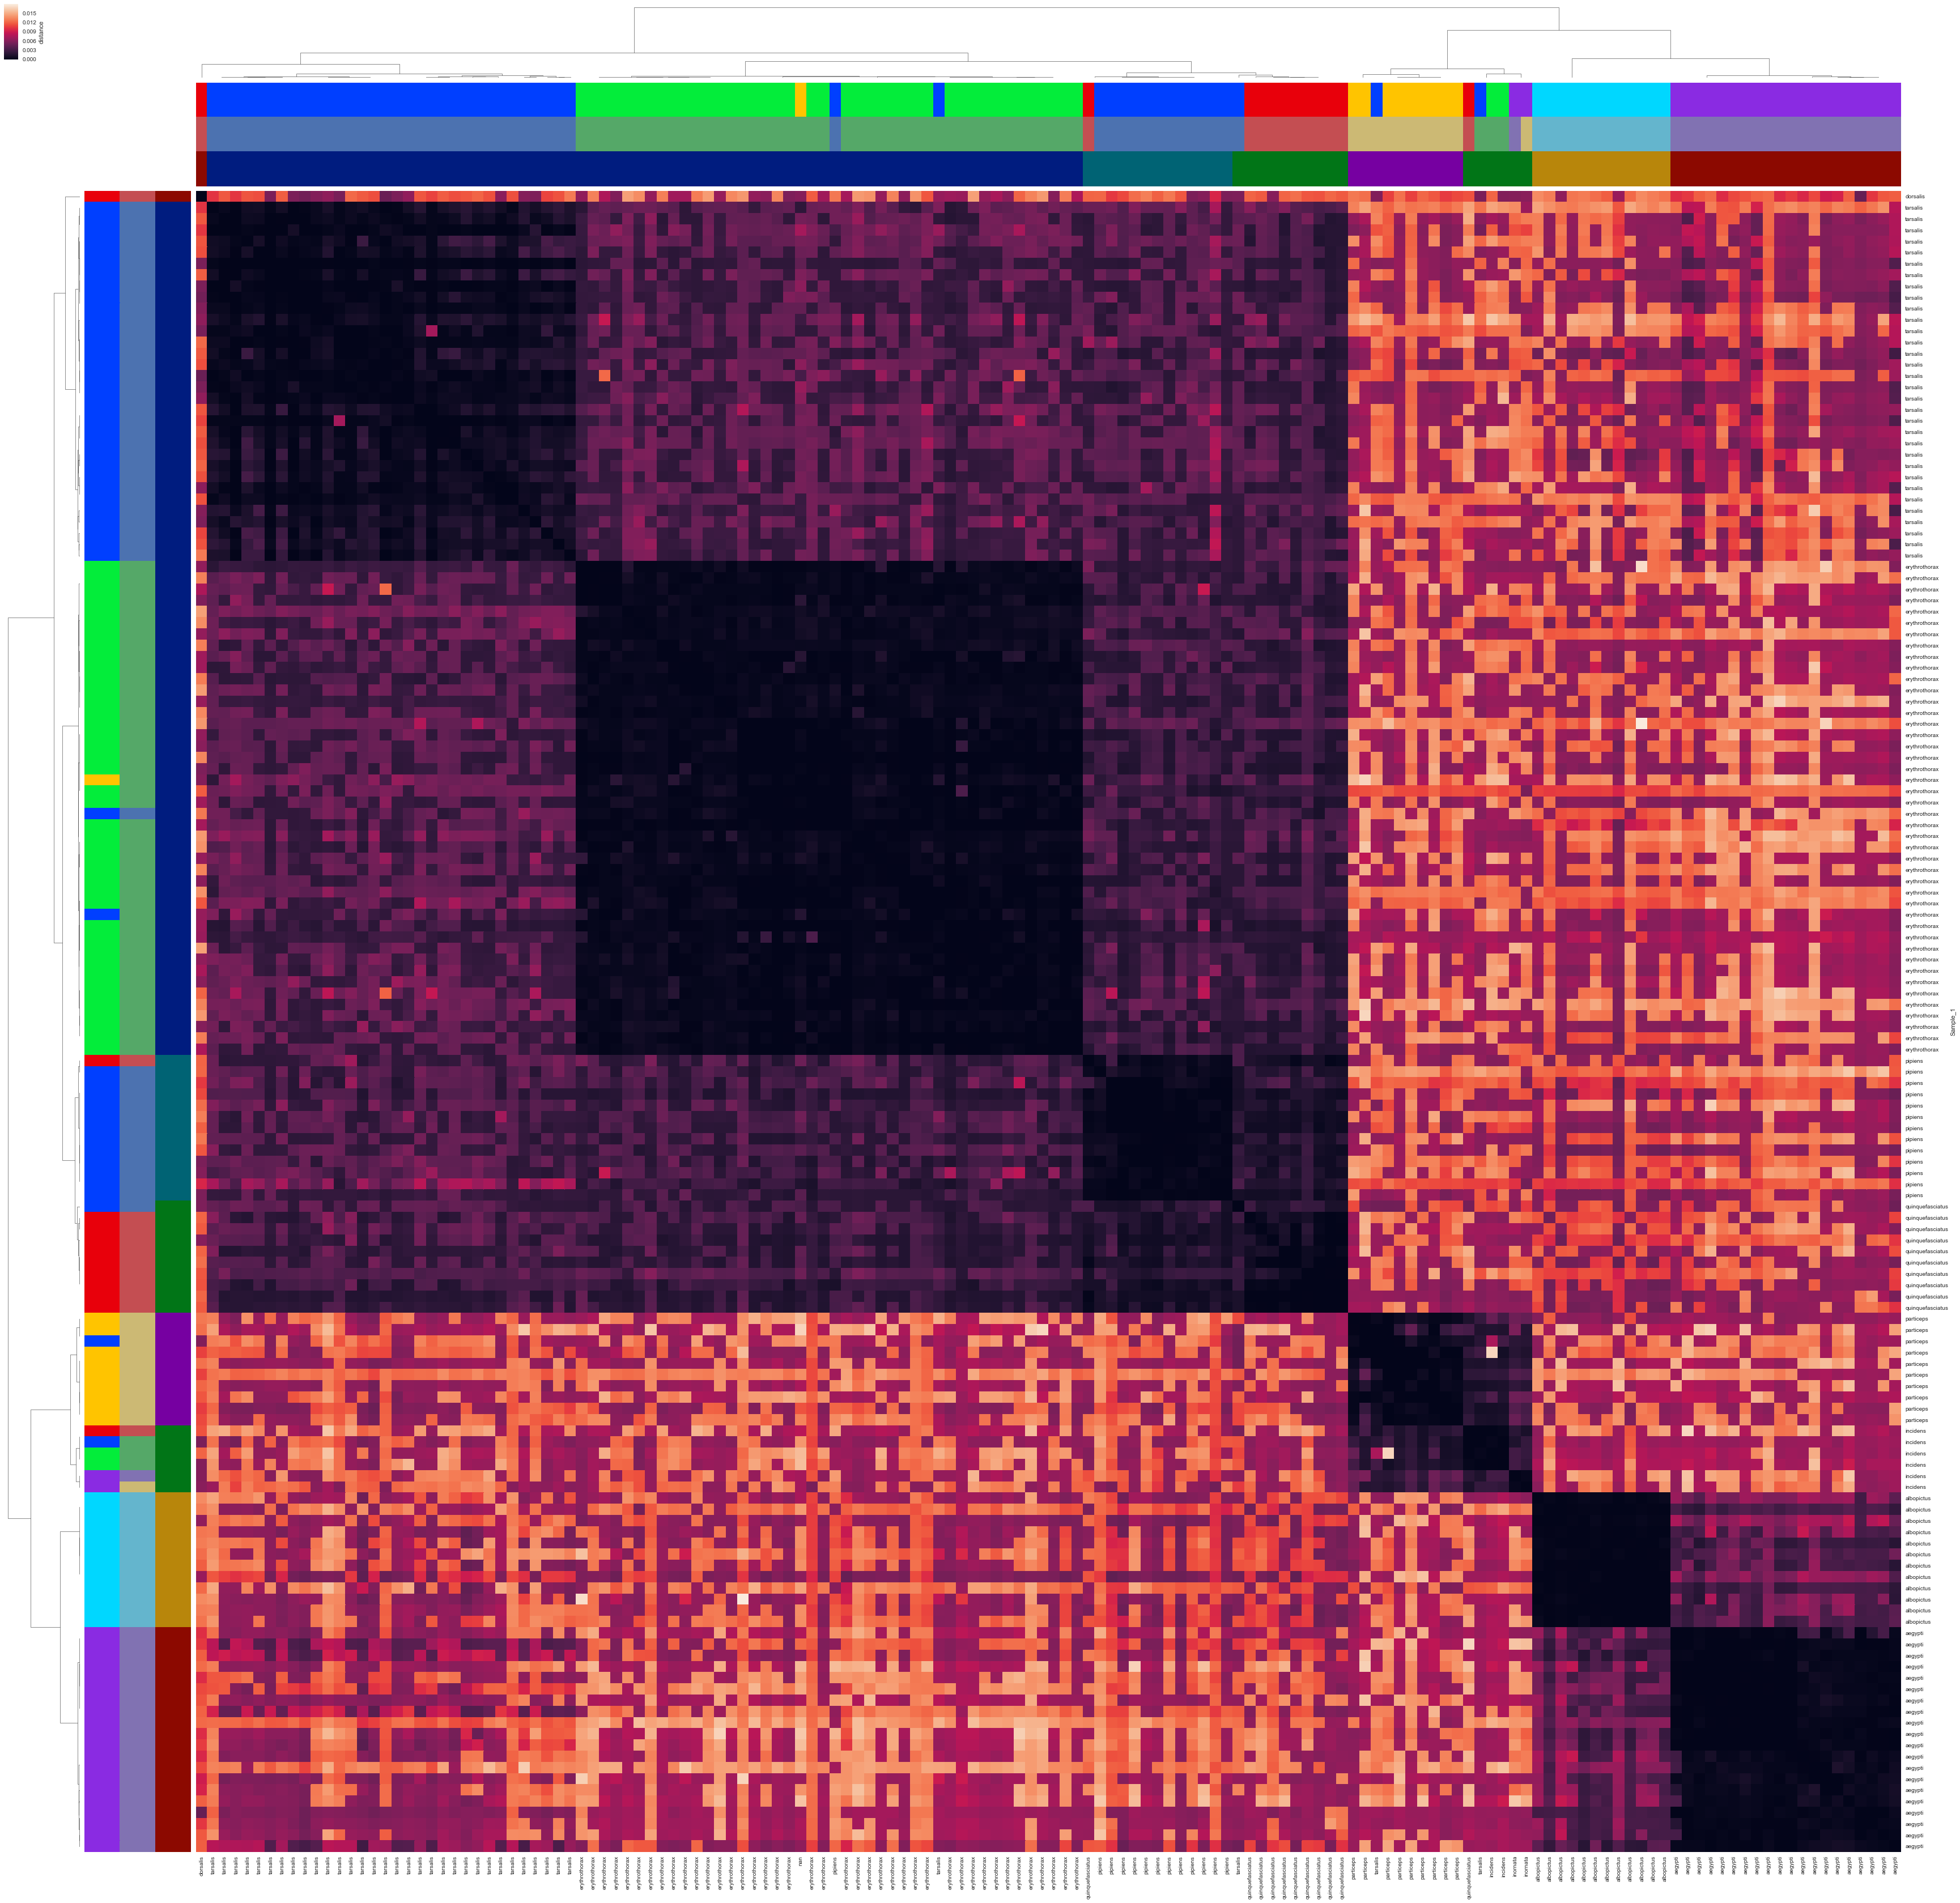

In [20]:
wrap_clustermap_and_mismatches(
    total_samples,
    species_id,
    "_ksize_15",
    k=10, 
    figsize=(60,60), 
    values="SNP_distance", 
    diagonal=0
)

/Users/phoenix.logan/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/phoenix.logan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/phoenix.logan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

TypeError: unsupported operand type(s) for -: 'Text' and 'float'

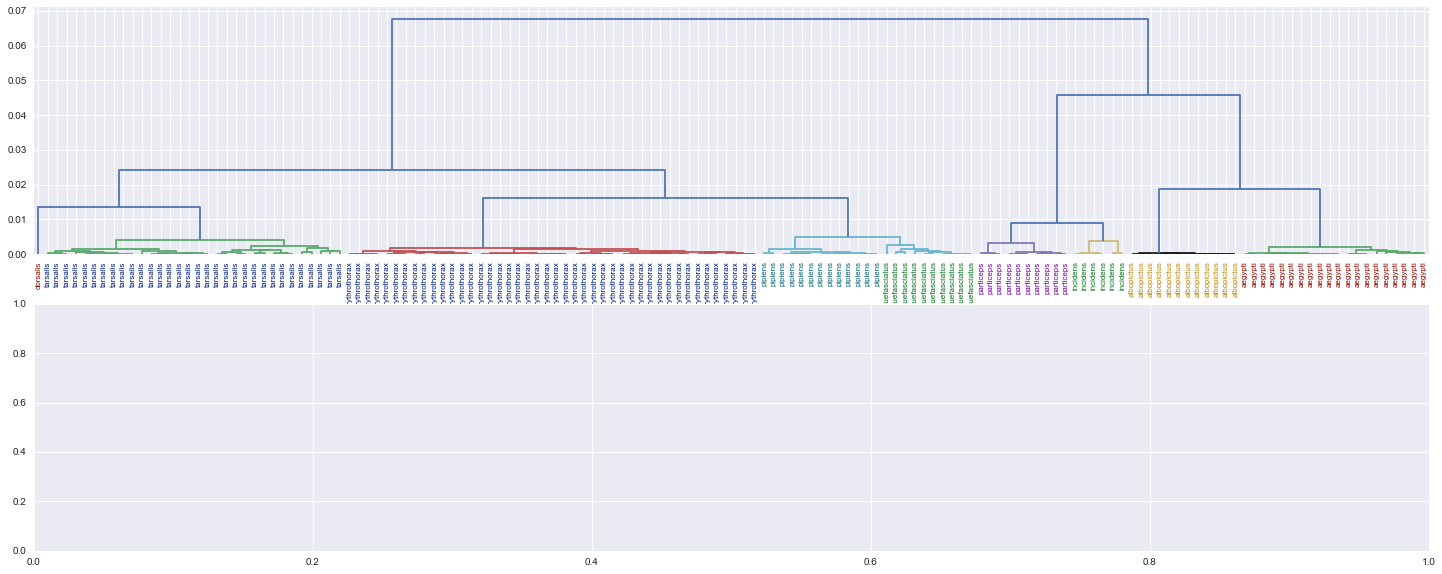

In [14]:

# import importlib
# importlib.import_module('mpl_toolkits').__path__
# from mpl_toolkits.axes.grid1 import make_axes_locatable

dd_pivot_w_ska_labels, *_ = join_on_ska_labels(
    total_samples, 
    species_id,
    "_ksize_15", 
    10, 
    values="SNP_distance"
)

original_species_coloring = dict(
    zip(
        dd_pivot_w_ska_labels.index.get_level_values(2).unique(), 
        sns.color_palette("bright", 12)
    )
)

sourmash_species_coloring = dict(
    zip(
        dd_pivot_w_ska_labels.index.get_level_values(4).unique(), 
        sns.color_palette("deep", 12)
    )
)

ska_species_coloring = dict(
    zip(
        dd_pivot_w_ska_labels.index.get_level_values(6).unique(), 
        sns.color_palette("dark", 13)
    )
)   

pivot_index = dd_pivot_w_ska_labels.reset_index()

key_colors_original = pivot_index["visual_species"].map(original_species_coloring)
key_colors_sourmash = pivot_index["sourmash_species"].map(sourmash_species_coloring)
key_colors_ska = pivot_index["ska_species"].map(ska_species_coloring)

#     key_colors_original = pivot_index.get_level_values(2).map(original_species_coloring)
#     key_colors_sourmash = pivot_index.get_level_values(4).map(sourmash_species_coloring)
#     key_colors_ska = pivot_index.get_level_values(6).map(ska_species_coloring)

key_colors_labels = [
    key_colors_original, 
    key_colors_sourmash, 
    key_colors_ska
]

cdist = scipy.spatial.distance.squareform(dd_pivot_w_ska_labels)
Z = shc.linkage(cdist, method="ward")
fig = plt.figure(figsize=(25, 10))
plt.subplot(211)
dn = shc.dendrogram(
    Z, 
    leaf_font_size=8, 
#     row_colors=key_colors_labels, 
#     col_colors=key_colors_labels,
    labels=dd_pivot_w_ska_labels.index.get_level_values(6), 
    color_threshold=0.008
)

ax = plt.gca()
xlbls = ax.get_xmajorticklabels()

for lbl in xlbls:
    lbl.set_color(ska_species_coloring[lbl.get_text()])
    

In [83]:
e = xlbls[0]

In [96]:
e.get_text()

'dorsalis'

In [97]:
e.get_text()


'dorsalis'

/Users/phoenix.logan/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


silhouettes:  SNP Distance 0.8177106340781412 Mash Distance: 0.2854478012102976


/Users/phoenix.logan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/phoenix.logan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


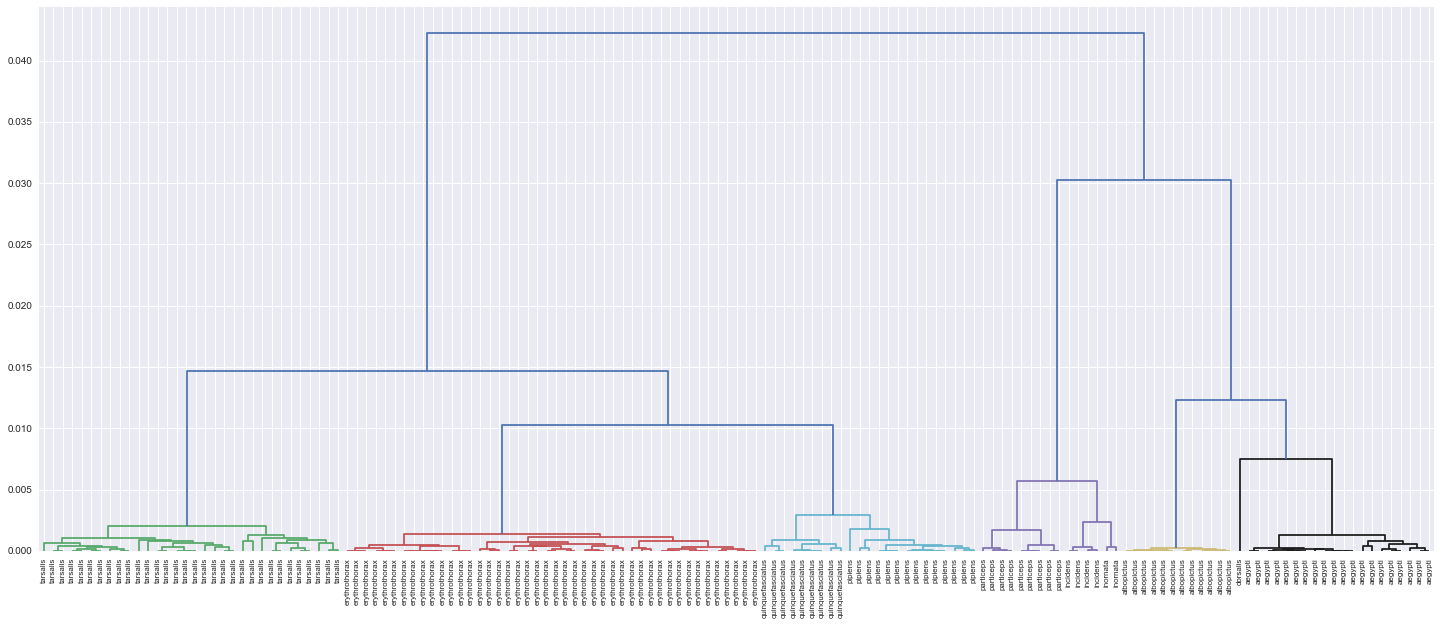

In [18]:
# Silhouette scores comparing clustering with mash-like distance and snp distance

silhouette_snp = get_silhouette_score(
    t_nf,
    species_id,
    "_ksize_15",
    values="SNP_distance"
)

silhouette_mash = get_silhouette_score(
    t_nf,
    species_id,
    "_ksize_15",
    values="Mash-like_distance"
)

print(
    "silhouettes: ",
    f"SNP Distance {silhouette_snp}", 
    f"Mash Distance: {silhouette_mash}"
)

dn = hierarchical_clustering(
    t_nf, 
    species_id,
    "_ksize_15", 
    10, 
    values="SNP_distance"
)


In [61]:
original_species_coloring = dict(
    zip(
        dd_pivot_w_ska_labels.index.get_level_values(2).unique(), 
        sns.color_palette("bright", 12)
    )
)

sourmash_species_coloring = dict(
    zip(
        dd_pivot_w_ska_labels.index.get_level_values(4).unique(), 
        sns.color_palette("deep", 12)
    )
)

ska_species_coloring = dict(
    zip(
        dd_pivot_w_ska_labels.index.get_level_values(6).unique(), 
        sns.color_palette("dark", 13)
    )
)   

pivot_index = dd_pivot_w_ska_labels.reset_index()
#     raise ValueError


key_colors_original = pivot_index["visual_species"].map(original_species_coloring)
key_colors_sourmash = pivot_index["sourmash_species"].map(sourmash_species_coloring)
key_colors_ska = pivot_index["ska_species"].map(ska_species_coloring)

key_colors_labels = [
#         original_species_coloring,
#         sourmash_species_coloring,
#         ska_species_coloring
    key_colors_original, 
    key_colors_sourmash, 
    key_colors_ska
]

sns.clustermap(
        dd_pivot_w_ska_labels.reset_index().drop([
            "visual_genus", 
            "visual_species", 
            "sourmash_genus",
            "sourmash_species",
            "ska_genus",
            "ska_species"
        ], axis=1).set_index("Sample_1"),
        metric="correlation", 
#             row_colors=key_colors_labels, 
#             col_colors=key_colors_labels,
        figsize=figsize,
        col_linkage=linkage,
        row_linkage=linkage,
        cbar_kws={'label': 'distance'},
        xticklabels=dd_pivot_w_ska_labels.index.get_level_values(4),
        yticklabels=dd_pivot_w_ska_labels.index.get_level_values(6)
)

NameError: name 'figsize' is not defined

In [60]:
[x for x in species_id.index if x not in df.Sample_1.values]

['CMS_017_RNA_A_S6', 'CMS002_053a_Rb_S7_L004']

In [61]:
[x for x in df.Sample_1.values if x not in species_id.index]

['CMS_002_53a_Rb_S7_L004',
 'CMS_002_53a_Rb_S7_L004',
 'CMS_002_53a_Rb_S7_L004',
 'CMS_002_53a_Rb_S7_L004',
 'CMS_002_53a_Rb_S7_L004',
 'CMS_002_53a_Rb_S7_L004',
 'CMS_002_53a_Rb_S7_L004',
 'CMS_002_53a_Rb_S7_L004',
 'CMS_002_53a_Rb_S7_L004',
 'CMS_002_53a_Rb_S7_L004',
 'CMS_002_53a_Rb_S7_L004',
 'CMS_002_53a_Rb_S7_L004',
 'CMS_002_53a_Rb_S7_L004',
 'CMS_002_53a_Rb_S7_L004',
 'CMS_002_53a_Rb_S7_L004']

In [ ]:
[x for x in species_id.index if x not in df.Sample_1.values]

In [111]:
geolocator = Nominatim(user_agent="mosquito_locator")

# final_pivot_w_labels, cluster_map, linkage = join_on_ska_labels(
# #     "s3://phoenixlogan-sketches/k15_10000000.distances.tsv",
#     "~/data/11-14-2019/ksize_15.distances.tsv",
#     species_id,
# #     "_001_10000000_15",
#     "_ksize_15",
#     10
# )

# dd_pivot_w_ska_labels, cluster_map, linkage = join_on_ska_labels(
#     total_samples,
#     species_id,
#     "_ksize_15",
#     k=10,
#     values="SNP_distance", 
# )

new_metadata = pd.read_csv(
    "/Users/phoenix.logan/code/skeeters/data/metadata/CMS001_CMS002_MergedAnnotations.csv", 
    header = 0, 
    index_col = "czbiohub-mosquito_sequences_id",
)

counties = [
    'Alameda County',
    'San Diego County',
    'San Bernardino County',
    'Riverside County',
    'Placer County',
    'Sacramento County',
] 

all_metadata = pd.merge(
    dd_pivot_w_ska_labels.reset_index()[[
        "Sample_1", 
        "visual_genus", 
        "visual_species", 
        "sourmash_genus",
        "sourmash_species",
        "ska_genus",
        "ska_species"
    ]],
    new_metadata.drop([
        'NewIDseqName', 
        'OldIDseqName',
#         'raw_sequence_run_directory',
        'visual_genus',
        'visual_species',
#         'compute_genus',
#         'compute_species'
        "sourmash_genus",
        "sourmash_species",
        "ska_genus",
        "ska_species"
    ], axis=1),
    how='left',
    left_on="Sample_1", 
    right_index=True
).set_index("Sample_1")


def get_location(row):
    lat = row['collection_lat']
    long = row['collection_long']
    if np.isnan(lat) or np.isnan(long):
        return np.nan
    else:
        print(f"finding location for {lat}, {long}")
        loc = geolocator.reverse(f"{lat}, {long}", timeout=1000)
        return loc.address
    
    
def find_location(row):
    lat = row['collection_lat']
    long = row['collection_long']
    
    if np.isnan(lat) or np.isnan(long):
        return np.nan
    else:
        return unique_dict[(lat, long)]
    
    
def get_county(row):
    address = row['location_address']
    
    if type(address) != str:
        return np.nan
    
    else:
        if 'Alameda' in address:
            return 'Alameda'

        elif 'San Diego' in address:
            return 'San Diego'

        elif 'San Bernardino' in address:
            return 'San Bernardino'

        elif 'Riverside' in address:
            return 'Riverside'

        elif 'Placer' in address:
            return 'Placer'

        elif 'Sacramento' in address:
            return 'Sacramento'

        else:
            return 'Other'

        
def get_region(row):
    
    county = row['county']
    northern_counties = [
        'Alameda',
        'Placer',
        'Sacramento'
    ]
    southern_counties = [
        'San Bernardino',
        'Riverside', 
        'San Diego'
    ]
    
    if type(county) != str:
        return np.nan
    
    else:
        if county in northern_counties:
            return 'Northern California'
        
        elif county in southern_counties:
            return 'Southern California'
        
        else:
            return 'Other'
        

# unique_locs = [(x[0], x[1]) for x in all_metadata[['collection_lat', 'collection_long']].values]

# unique_dict = {
#     i: get_location(i[0], i[1])
#     for i in set(unique_locs)
# }
        
all_metadata['location_address'] = all_metadata.apply(get_location, axis=1)
all_metadata['county'] = all_metadata.apply(get_county, axis=1)
all_metadata['region'] = all_metadata.apply(get_region, axis=1)

label_dicts = [
    all_metadata[i]
    for i in all_metadata.keys()
]

# label_dicts

all_metadata_pivot = pd.merge(
    dd_pivot_w_ska_labels.reset_index(),
    all_metadata.reset_index()[[
        "Sample_1",
        "sex",
        "county",
        "region",
        "life_stage"
    ]],
    how='left',
    left_on="Sample_1", 
    right_on="Sample_1",
).set_index([
    "Sample_1", 
    "visual_genus", 
    "visual_species",
    "sourmash_genus",
    "sourmash_species",
    "ska_genus",
    "ska_species",
    "sex",
    "county",
    "region",
    "life_stage"
])
all_metadata_pivot.head()

all_meta_lookup = all_metadata.reset_index().set_index("Sample_1").to_dict('index')



finding location for 38.836781, -121.39119
finding location for 37.55697, -122.07938
finding location for 32.7981529, -116.9544084
finding location for 32.7996185, -116.93932029999999
finding location for 32.7152395, -117.11484240000001
finding location for 32.5542907, -117.04828
finding location for 32.5542907, -117.04828
finding location for 32.5542907, -117.04828
finding location for 32.5542907, -117.04828
finding location for 32.5542907, -117.04828
finding location for 32.6952215, -117.1221922
finding location for 32.6952215, -117.1221922
finding location for 32.760258, -117.0813933
finding location for 32.7962659, -116.9594824
finding location for 32.940749100000005, -117.21652390000001
finding location for 32.940749100000005, -117.21652390000001
finding location for 32.940749100000005, -117.21652390000001
finding location for 32.940749100000005, -117.21652390000001
finding location for 32.940749100000005, -117.21652390000001
finding location for 32.940749100000005, -117.216523900

In [116]:
# fill in the missing data
all_meta_lookup['CMS_058_RNA_A_S9']['visual_species'] ='erythrothorax'
all_meta_lookup['CMS_058_RNA_A_S9']['visual_genus'] ='Culex'
all_meta_lookup['CMS_058_RNA_A_S9']['county'] =''
all_meta_lookup['CMS_058_RNA_A_S9']['collection_date'] =''
all_meta_lookup['CMS_058_RNA_A_S9']['collection_lat'] =''
all_meta_lookup['CMS_058_RNA_A_S9']['collection_long'] =''
all_meta_lookup['CMS_058_RNA_A_S9']['region'] =''


all_meta_lookup['CMS_037_RNA_A_S21']['county'] =''
all_meta_lookup['CMS_037_RNA_A_S21']['collection_lat'] =''
all_meta_lookup['CMS_037_RNA_A_S21']['collection_long'] =''
all_meta_lookup['CMS_037_RNA_A_S21']['region'] =''

all_meta_lookup['CMS_032_RNA_A_S7']['collection_date'] =''

In [117]:

def getNewick(node, newick, parentdist, leaf_names):
    if node.is_leaf():
        return "%s:%.2f%s" % (leaf_names[node.id], parentdist - node.dist, newick)
    else:
        if len(newick) > 0:
            newick = "):%.2f%s" % (parentdist - node.dist, newick)
        else:
            newick = ");"
        newick = getNewick(node.get_left(), newick, node.dist, leaf_names)
        newick = getNewick(node.get_right(), ",%s" % (newick), node.dist, leaf_names)
        newick = "(%s" % (newick)
        return newick
    
labels = list(dd_pivot_w_ska_labels.index.get_level_values(0))
id2name = dict(zip(range(len(labels)), labels))
cdist = scipy.spatial.distance.squareform(dd_pivot_w_ska_labels)
Z = shc.linkage(cdist, method="ward")
T = shc.to_tree(Z , rd=False )

newick = getNewick(T, "", T.dist, id2name)


In [118]:
greens = list(reversed(sns.light_palette("#48a365", 4).as_hex()))
blues = list(reversed(sns.light_palette("#4c72a5", 4).as_hex()))
tans = list(reversed(sns.light_palette("#e1c72f", 4).as_hex()))

flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
county_colors = list(reversed(sns.color_palette(flatui).as_hex()))

gytis_palette = [
            "#4c72a5",
            "#48a365",
            "#d0694a",
            "#e1c72f",
            "#cc79a7",
            "#77bedb",
            "#7f6e85",
            "#ccc197",
            "#87CEFF",
            "#3b9072",
            "#b09977",
            "#f05129",
            "#922428",
            "#f5bd42"
] 

In [119]:
t = Tree(newick)
ts = TreeStyle()


# Culex
nst1 = NodeStyle()
# nst1["bgcolor"] = greens[0]

nst2 = NodeStyle()
# nst2["bgcolor"] = greens[1]

nst3 = NodeStyle()
# nst3["bgcolor"] = greens[2]

nst4 = NodeStyle()
# nst4["bgcolor"] = greens[3]

# Aedes
nst5 = NodeStyle()
# nst5["bgcolor"] = blues[0]

nst6 = NodeStyle()
# nst6["bgcolor"] = blues[1]

nst7 = NodeStyle()
# nst7["bgcolor"] = blues[2]

# Culiseta
nst8 = NodeStyle()
# nst8["bgcolor"] = tans[0]

nst9 = NodeStyle()
# nst9["bgcolor"] = tans[1]

nst10 = NodeStyle()
# nst10["bgcolor"] = tans[2]

nst11 = NodeStyle()
# nst11["bgcolor"] = tans[3]




# (culex, erythrothorax) = (255, 166, 0)
# (culex, quinquefasciatus) = (204,132,0) 
# (culex, tarsalis) = (163,105,0)
# (culex, pipiens) = (255,210,127)
# (Aedes, aegypti) = (255,99,97)
# (Aedes, albopictus) = (255,161,160)
# (Aedes, dorsalis) = (178,69,67)
# (Culiseta, particeps) = (188,80,144)
# (Culiseta, incidens) = (214,150,188) 
# (Culiseta, inornata) = (112,48,86) 

species_style_lookup = {
    'erythrothorax': nst1, 
    'quinquefasciatus': nst2, 
    'tarsalis': nst3, 
    'pipiens': nst4,
    'aegypti': nst5, 
    'albopictus': nst6,
    'dorsalis': nst7, 
    'particeps': nst8, 
    'incidens': nst9,
    'inornata': nst10
}

county_style_lookup = {
     'Alameda': greens[0],
#      'San Diego': tans[0],
     'San Diego': "purple",
     'San Bernardino': tans[2],   
     'Riverside': tans[3],
     'Placer': greens[2],
     'Sacramento': greens[3] 
}
# counties = list(all_metadata["county"].unique()) + [""]
# county_to_color_lookup = dict(zip(counties, reds))

sample_names = all_meta_lookup.keys()
for s in sample_names:
    visual_species = all_meta_lookup[s]["visual_species"]  
    style = species_style_lookup[visual_species]

    county = all_meta_lookup[s]["county"]
#     print(county)
    try:
        style["bgcolor"] = county_style_lookup[county]
    except:
        print("no county information for, ", county)
    node = [i.set_style(style) for i in t.search_nodes(name=s)]

no county information for,  
no county information for,  


In [ ]:
code2name = dict(
(sn, all_meta_lookup[sn]["county"]) for sn in all_meta_lookup.keys()
)

# code2name

In [ ]:
nameFace = faces.AttrFace("name", fsize=20, fgcolor="#009000")

def mylayout(node):
    # If node is a leaf, add the nodes name and a its scientific
    # name
    if node.is_leaf():
        # Add an static face that handles the node name
        faces.add_face_to_node(nameFace, node, column=0)
        # We can also create faces on the fly
        longNameFace = faces.TextFace(code2name[node.name])
        faces.add_face_to_node(longNameFace, node, column=0)

        # text faces support multiline. We add a text face
        # with the whole description of each leaf.
#         descFace = faces.TextFace(code2desc[node.name], fsize=10)
#         descFace.margin_top = 10
#         descFace.margin_bottom = 10
#         descFace.border.margin = 1

        # Note that this faces is added in "aligned" mode
#         faces.add_face_to_node(descFace, node, column=0, aligned=True)

        # Sets the style of leaf nodes
#         node.img_style["size"] = 12
#         node.img_style["shape"] = "circle"
#     #If node is an internal node
#     else:
#         # Sets the style of internal nodes
#         node.img_style["size"] = 6
#         node.img_style["shape"] = "circle"
#         node.img_style["fgcolor"] = "#000000"

    # If an internal node contains more than 4 leaves, add the
    # images of the represented species sorted in columns of 2
    # images max.
#     if len(node)>=4:
#         col = 0
#         for i, name in enumerate(set(node.get_leaf_names())):
#             if i>0 and i%2 == 0:
#                 col += 1
#             # Add the corresponding face to the node
#             if name.startswith("Dme"):
#                 faces.add_face_to_node(flyFace, node, column=col)
#             elif name.startswith("Dre"):
#                 faces.add_face_to_node(fishFace, node, column=col)
#             elif name.startswith("Mms"):
#                 faces.add_face_to_node(mouseFace, node, column=col)
#             elif name.startswith("Ptr"):
#                 faces.add_face_to_node(chimpFace, node, column=col)
#             elif name.startswith("Hsa"):
#                 faces.add_face_to_node(humanFace, node, column=col)
#             elif name.startswith("Cfa"):
#                 faces.add_face_to_node(dogFace, node, column=col)

            # Modifies this node's style
#             node.img_style["size"] = 16
#             node.img_style["shape"] = "sphere"
#             node.img_style["fgcolor"] = "#AA0000"

    # If leaf is "Hsa" (homo sapiens), highlight it using a
    # different background.
#     if node.is_leaf() and node.name.startswith("Hsa"):
#         node.img_style["bgcolor"] = "#9db0cf"

NameError: name 'mylayout' is not defined

In [ ]:
t.render("visual_labels.svg", tree_style=ts)

In [ ]:
# t.get_common_ancestor("pipiens", "quinquefasciatus")
node = t.search_nodes(name="pipiens")

In [ ]:

t = Tree(newick)
ts = TreeStyle()
nst1 = NodeStyle()

# Culex
nst1["bgcolor"] = greens[0]

nst2 = NodeStyle()
nst2["bgcolor"] = greens[1]

nst3 = NodeStyle()
nst3["bgcolor"] = greens[2]

nst4 = NodeStyle()
nst4["bgcolor"] = greens[3]

# Aedes
nst5 = NodeStyle()
nst5["bgcolor"] = blues[0]

nst6 = NodeStyle()
nst6["bgcolor"] = blues[1]

nst7 = NodeStyle()
nst7["bgcolor"] = blues[2]

# Culiseta
nst8 = NodeStyle()
nst8["bgcolor"] = tans[0]

nst9 = NodeStyle()
nst9["bgcolor"] = tans[1]

nst10 = NodeStyle()
nst10["bgcolor"] = tans[2]

nst11 = NodeStyle()
nst11["bgcolor"] = tans[3]




# (culex, erythrothorax) = (255, 166, 0)
# (culex, quinquefasciatus) = (204,132,0) 
# (culex, tarsalis) = (163,105,0)
# (culex, pipiens) = (255,210,127)
# (Aedes, aegypti) = (255,99,97)
# (Aedes, albopictus) = (255,161,160)
# (Aedes, dorsalis) = (178,69,67)
# (Culiseta, particeps) = (188,80,144)
# (Culiseta, incidens) = (214,150,188) 
# (Culiseta, inornata) = (112,48,86) 

species_style_lookup = {
    'erythrothorax': nst1, 
    'quinquefasciatus': nst2, 
    'tarsalis': nst3, 
    'pipiens': nst4,
    'aegypti': nst5, 
    'albopictus': nst6,
    'dorsalis': nst7, 
    'particeps': nst8, 
    'incidens': nst9,
    'inornata': nst10
}

counties = list(all_metadata["county"].unique()) + [""]
county_to_color_lookup = dict(zip(counties, county_colors))

sample_names = all_meta_lookup.keys()
for s in sample_names:
    ska_species = all_meta_lookup[s]["ska_species"]
#     county = all_meta_lookup[s]["county"]
    style = species_style_lookup[ska_species]
#     try:
#         style["bgcolor"] = county_to_color_lookup[county]
#     style = species_style_lookup[ska_species]
#     try:
#         style["fgcolor"] = county_to_color_lookup[county]
#         style["size"] = 5
#     except:
#         print("no county information for, ", county)
    node = [i.set_style(style) for i in t.search_nodes(name=s)]

In [ ]:
ts.title.add_face(TextFace("Assignment by Collection Site County", fsize=30), column=0)
# for k, v in species_style_lookup.items():
#     ts.legend.add_face(CircleFace(10, v["bgcolor"]), column=0)
#     ts.legend.add_face(TextFace(k), column=1)
for k, v in county_style_lookup.items():
    ts.legend.add_face(CircleFace(10, v), column=0)
    ts.legend.add_face(TextFace(k), column=1)
    
ts.show_leaf_name=True
ts.branch_vertical_margin = 10
# ts.mode = "c"
# ts.arc_start = -180
# ts.arc_span = 180
# ts.layout_fn = mylayout
t.show(tree_style=ts)


# newick

<hr>

## Exploration

In [146]:
table = wrap_clustermap_and_mismatches(
#     "s3://phoenixlogan-sketches/k15_10000000.distances.tsv",
    "ksize_15_raw.distances.tsv",
    species_id,
    "_ksize_15",
    k=10,
    figsize = (60,60), 
    values="SNP_distance", 
    diagonal=0
)

/Users/phoenix.logan/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/phoenix.logan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/phoenix.logan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [147]:
# table.index.get_level_values(0)
table

,,,,,,,CMS002_053a_Rb_S7_L004,CMS_001_RNA_A_S1,CMS_002_10a_Rb_S119_L004,CMS_002_13a_Rb_S120_L004,CMS_002_16a_Rb_S121_L004,CMS_002_17a_Rb_S122_L004,CMS_002_17b_Rb_S123_L004,CMS_002_17c_Rb_S124_L004,CMS_002_17d_Rb_S125_L004,CMS_002_17e_Rb_S126_L004,...,CMS_050_RNA_A_S23,CMS_051_RNA_A_S8,CMS_052_RNA_A_S7,CMS_053_RNA_A_S8,CMS_054_RNA_A_S11,CMS_055_RNA_A_S9,CMS_056_RNA_A_S10,CMS_057_RNA_A_S11,CMS_058_RNA_A_S9,CMS_059_RNA_A_S10
Sample_1,visual_genus,visual_species,sourmash_genus,sourmash_species,ska_genus,ska_species,,,,,,,,,,,,,,,,,,,,,
CMS002_053a_Rb_S7_L004,Culex,pipiens,Culex,pipiens,Culex,erythrothorax,0.000000,0.000196,0.001703,0.001656,0.006803,0.006993,0.007157,0.007046,0.007164,0.006995,...,0.000130,0.002589,0.000000,0.000120,0.002081,0.000000,0.000000,0.000118,0.000000,0.002072
CMS_002_27b_Rb_S153_L004,Culex,quinquefasciatus,Culex,quinquefasciatus,Culex,pipiens,0.002093,0.003095,0.000204,0.000407,0.006417,0.006431,0.006743,0.006680,0.006132,0.006680,...,0.001955,0.002444,0.001779,0.001892,0.000281,0.001894,0.001622,0.003295,0.002487,0.000456
CMS_002_7a_Rb_S118_L004,Culex,quinquefasciatus,Culex,quinquefasciatus,Culiseta,incidens,0.007397,0.007382,0.006635,0.007339,0.006987,0.007747,0.007251,0.007909,0.007351,0.006858,...,0.006529,0.007307,0.006660,0.006268,0.006553,0.007454,0.006927,0.006645,0.008153,0.006965
CMS_025_RNA_A_S7,Culex,tarsalis,Culiseta,particeps,Culiseta,particeps,0.006456,0.006506,0.006668,0.006927,0.007124,0.006571,0.006676,0.007206,0.006394,0.006822,...,0.006281,0.006521,0.007105,0.006205,0.006219,0.007060,0.006616,0.006643,0.007341,0.006294
CMS_026_RNA_A_S18,Culex,tarsalis,Culiseta,incidens,Culiseta,incidens,0.006088,0.007179,0.005842,0.006129,0.006725,0.006912,0.006747,0.007181,0.007133,0.007186,...,0.006184,0.006335,0.006193,0.006130,0.005832,0.006331,0.006283,0.006480,0.007073,0.006649
CMS_040_RNA_A_S21,Culex,tarsalis,Culex,tarsalis,Culex,pipiens,0.001785,0.001924,0.001294,0.001276,0.006369,0.006313,0.006213,0.006607,0.006405,0.006600,...,0.002128,0.002311,0.001993,0.001779,0.001099,0.001800,0.001638,0.001809,0.001732,0.001243
CMS_045_RNA_A_S2,Culex,tarsalis,Culex,erythrothorax,Culex,erythrothorax,0.000222,0.000399,0.002248,0.002321,0.007331,0.007578,0.007287,0.007158,0.007349,0.008949,...,0.000000,0.002869,0.000368,0.000000,0.002240,0.000126,0.000250,0.000353,0.000867,0.002364
CMS_058_RNA_A_S9,NaN,NaN,Culex,erythrothorax,Culex,erythrothorax,0.000000,0.000528,0.001679,0.002025,0.006877,0.007182,0.007557,0.007459,0.007599,0.006926,...,0.000994,0.002230,0.000114,0.000000,0.002041,0.000238,0.000000,0.000343,0.000000,0.002843


In [17]:
species_id.head()

,visual_genus,visual_species,sourmash_species,sourmash_genus
,,,,
CMS_001_RNA_A_S1,Culex,erythrothorax,erythrothorax,Culex
CMS_002_RNA_A_S1,Culex,tarsalis,tarsalis,Culex
CMS_003_RNA_A_S2,Culiseta,particeps,particeps,Culiseta
CMS_004_RNA_A_S2,Culex,pipiens,pipiens,Culex
CMS_005_RNA_A_S3,Culiseta,incidens,incidens,Culiseta


In [19]:
[x for x in species_id.index if x not in dd_pivot_w_ska_labels.index.get_level_values(0)]

[]

In [153]:
# for x in t["Sample 1"]:
#     xs = x.split("_ksize_15")[0]
#     if xs not in dd_pivot_w_ska_labels.index.get_level_values(0):
#         print("not in original: ", xs)

for x in nm["id"]:
    if x not in dd_pivot_w_ska_labels.index.get_level_values(0):
        print("not in original: ", x)        

not in original:  CMS_060_RNA_A_S12


In [144]:
ts = [x.split("_ksize_9")[0] for x in t["Sample 1"]]

In [145]:
for x in nm["id"]:
    if x not in ts:
        print("not in original: ", x)

not in original:  CMS_002_20b_Rb_S132_L004


In [138]:
for i in dd_pivot_w_ska_labels.index.get_level_values(0):
    print(i)

CMS002_053a_Rb_S7_L004
CMS_001_RNA_A_S1
CMS_002_10a_Rb_S119_L004
CMS_002_13a_Rb_S120_L004
CMS_002_16a_Rb_S121_L004
CMS_002_17a_Rb_S122_L004
CMS_002_17b_Rb_S123_L004
CMS_002_17c_Rb_S124_L004
CMS_002_17d_Rb_S125_L004
CMS_002_17e_Rb_S126_L004
CMS_002_18a_Rb_S128_L004
CMS_002_18b_Rb_S129_L004
CMS_002_19a_Rb_S130_L004
CMS_002_1a_Rb_S116_L004
CMS_002_20a_Rb_S131_L004
CMS_002_20c_Rb_S133_L004
CMS_002_20d_Rb_S134_L004
CMS_002_20e_Rb_S135_L004
CMS_002_21a_Rb_S136_L004
CMS_002_22a_Rb_S137_L004
CMS_002_23a_Rb_S138_L004
CMS_002_25a_Rb_S140_L004
CMS_002_25b_Rb_S141_L004
CMS_002_25c_Rb_S142_L004
CMS_002_25d_Rb_S143_L004
CMS_002_25e_Rb_S144_L004
CMS_002_25f_Rb_S145_L004
CMS_002_26a_Rb_S146_L004
CMS_002_26b_Rb_S147_L004
CMS_002_26c_Rb_S148_L004
CMS_002_26d_Rb_S149_L004
CMS_002_26e_Rb_S150_L004
CMS_002_27a_Rb_S152_L004
CMS_002_27b_Rb_S153_L004
CMS_002_28a_Rb_S154_L004
CMS_002_28b_Rb_S155_L004
CMS_002_28c_Rb_S156_L004
CMS_002_28d_Rb_S157_L004
CMS_002_28e_Rb_S158_L004
CMS_002_29a_Rb_S159_L004
CMS_002_29b

In [ ]:
# relabelled / mismatches

table_mismatches = table.reset_index()[['Sample_1','visual_genus','visual_species','sourmash_genus','sourmash_species','ska_genus','ska_species']]
table_mismatches.dropna()

/Users/phoenix.logan/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


silhouettes:  SNP Distance 0.8165919686072226 Mash Distance: 0.30983691818864184


/Users/phoenix.logan/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/phoenix.logan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/phoenix.logan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

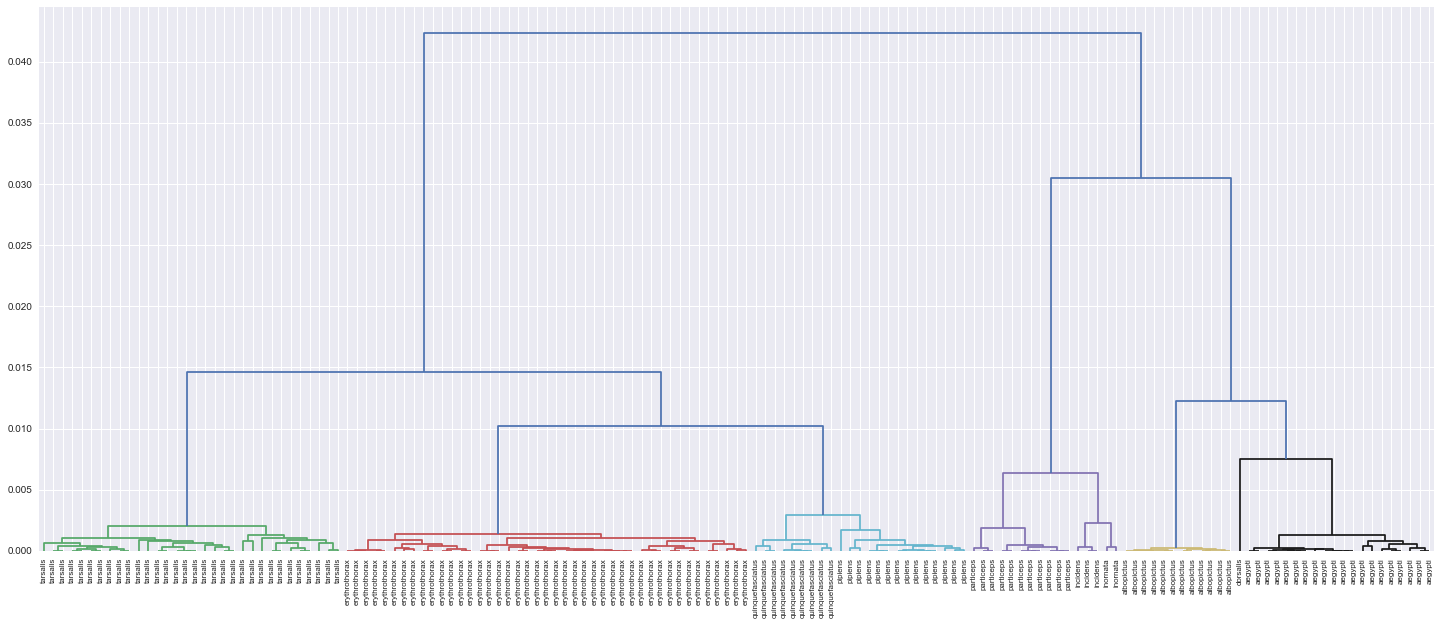

In [9]:
dn = hierarchical_clustering(
    "~/data/11-14-2019/ksize_15.distances.tsv",
    species_id,
    "_ksize_15",
    10,
    values="SNP_distance"
)

In [ ]:
%debug